# Loading Data

In [1]:
import pandas as pd

posts_df = pd.read_csv("../input/reddit-selfposts/rspct.tsv", sep='\t')
subred_df = pd.read_csv("../input/reddit-selfposts/subreddit_info.csv").set_index(['subreddit'])
df = posts_df.join(subred_df, on='subreddit')
df.head(5)

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support,NaN,True,NaN
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom,NaN,True,NaN
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells,NaN,True,NaN
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu,intel,True,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013000 entries, 0 to 1012999
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   id                    1013000 non-null  object
 1   subreddit             1013000 non-null  object
 2   title                 1013000 non-null  object
 3   selftext              1013000 non-null  object
 4   category_1            1013000 non-null  object
 5   category_2            1013000 non-null  object
 6   category_3            136000 non-null   object
 7   in_data               1013000 non-null  bool  
 8   reason_for_exclusion  0 non-null        object
dtypes: bool(1), object(8)
memory usage: 62.8+ MB


## Standardizing Attribute Names

In [3]:
column_mapping = {
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',
}

df = df.rename(columns=column_mapping)
df.drop(columns=['category_3', 'in_data', 'reason_for_exclusion'], inplace=True)
df.head(5)

,id,subreddit,title,text,category,subcategory
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...",writing/stories,tech support
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,tv_show,teen mom
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,hardware/tools,doorbells
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...",electronics,cpu


In [4]:
# Limit the data to autos category
df = df[df['category'] == 'autos']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 2 to 1012979
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20000 non-null  object
 1   subreddit    20000 non-null  object
 2   title        20000 non-null  object
 3   text         20000 non-null  object
 4   category     20000 non-null  object
 5   subcategory  20000 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


# Cleaning Text Data

## Identify Noise with Regular Expressions

In [5]:
import re


RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text: str, min_len=10):
    """ Returns the share of suspicious characters in a text """
    
    return 0 if text is None or len(text) < min_len else len(RE_SUSPICIOUS.findall(text)) / len(text)

In [6]:
from tqdm.notebook import tqdm


tqdm.pandas()

df['impurity'] = df['text'].progress_apply(impurity , min_len=10)

df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head()

  0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
997126,Looking at buying a 335i with 39k miles and 11...,0.214716
626478,I'm looking to lease an a4 premium plus automa...,0.165099
138199,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L...,0.139130
647490,Bulbs Needed:<lb><lb><lb>**194 LED BULB x8**<l...,0.132411
542876,I currently have a deposit on a 2013 335is (CP...,0.129317


In [7]:
from typing import Callable
from collections import Counter


def count_words(ds: pd.Series, preprocess: Callable = None, min_freq: int = 2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    ds.progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [8]:
count_words(df['text'], preprocess=lambda t: re.findall(r'<[\w/]*>', t))

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
<lb>,100729
<tab>,642


It appears to be have two types of tokens which we can remove to improve our impurity 

## Removal with Regular Expressions

In [9]:
def clean(text):
    import html
    
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [10]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity'] = df['clean_text'].progress_apply(impurity, min_len=20)
df[['text', 'impurity']].sort_values(by='impurity',ascending=False).head()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
711988,"Mustang 2018, 2019, or 2020? Must Haves!!<lb><...",0.030864
957625,"At the dealership, they offered an option for ...",0.026455
836076,"I am looking at four Caymans, all are in a sim...",0.024631
222061,"Hello,<lb><lb>I came across this great looking...",0.022762
947793,The Mazda 3 hatchback I'm looking at is a 2007...,0.022099


## Character Normalization with textacy

In [11]:
! pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.2 MB/s eta 0:00:00
  Obtaining dependency information for floret~=0.10.0 from https://files.pythonhosted.org/packages/16/ee/388a5c76c9292f4bef85d7ef895005bb39a0899f8004e9daceb57b2bb0c9/floret-0.10.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for jellyfish>=0.8.0 from https://files.pythonhosted.org/packages/26/87/8d31224804af9dfa7b34657e083b67b24b322c41dd9464b52218c1a33890/jellyfish-1.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.9 MB/s eta 0:00:00


In [12]:
import textacy
import textacy.preprocessing as tprep

In [13]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

## Pattern-based Data Masking with textacy

In [14]:
from textacy.preprocessing.resources import RE_URL

count_words(df['clean_text'], preprocess=RE_URL.findall).head()

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2
http://imgur.com/gallery/XkRsw,2
https://www.youtube.com/watch?v=DuTI_jlA8v8,2


We can filter the/clean the urls and apply our normalize function to our text corpus

In [15]:
df['clean_text'] = df['clean_text'].progress_map(tprep.replace.urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)
df.head()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

,id,subreddit,title,text,category,subcategory,impurity,clean_text
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,0.0,Funny story. I went to college in Las Vegas. T...
56,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,0.0,"I am trying to determine which is faster, and ..."
78,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,0.0,Hello! Trying to find some information on repl...
270,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,0.0,_URL_ I have a IS 250 AWD from 2006. About 73K...
286,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,0.0,"Hi, new to this subreddit. I'm considering buy..."


In [16]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

# Tokenization

## Tokenization with Regular Expressions

In [17]:
RE_TOKEN = re.compile(r"""
                ( [#]?[@\w'’\.\-\:]*\w     # words, hashtags and email addresses
                | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
                | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
                )
                """, 
                re.VERBOSE
            )

def tokenize(text):
    return RE_TOKEN.findall(text)

In [18]:
text = """
    2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
    solution for today's problem. The code of module AC68 should be -1. 
    Have to think a bit... #goodnight ;-) 😩😬
"""

In [19]:
print(*tokenize(text), sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


## Tokenization with NLTK

In [20]:
import nltk

nltk.download('punkt')
print(*nltk.tokenize.word_tokenize(text), sep='|')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer(RE_TOKEN.pattern, flags=re.VERBOSE)
print(*tokenizer.tokenize(text), sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [22]:
tokenizer = nltk.tokenize.TweetTokenizer()
print(*tokenizer.tokenize(text), sep='|')

2019-08-|10|23:32|:|@pete|/|@louis|-|I|don't|have|a|well-designed|solution|for|today's|problem|.|The|code|of|module|AC68|should|be|-|1|.|Have|to|think|a|bit|...|#goodnight|;-)|😩|😬


In [23]:
tokenizer = nltk.tokenize.ToktokTokenizer()
print(*tokenizer.tokenize(text), sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


# Linguistic Processing with spaCy

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [25]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7d9b194b2020>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7d9b194b1660>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7d9b1980de70>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7d9b193d8140>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7d9b193d61c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7d9b1980e030>)]

As spacy loads multiple components together, one can disable them during the loading pahse by passing disable argument or later on via nlp.disable_pipes(...)

In [26]:
# nlp.disable_pipes('parser', 'ner')
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Processing Text

In [27]:
text = "Let's go to N.Y city"
doc = nlp(text)

In [28]:
for token in doc:
    print(token , end='|')

Let|'s|go|to|N.Y|city|

In [29]:
def display_doc(doc: spacy.tokens.Doc):
    tokens = []

    for i, token in enumerate(doc):
        tokens.append(dict(
            token=token,
            text=token.text,
            lemma_=token.lemma_,
            is_stop=token.is_stop,
            is_alpha=token.is_alpha,
            pos_=token.pos_,
            dep_=token.dep_,
            ent_type_=token.ent_type_,
            ent_iob_=token.ent_iob_,
        ))

    df = pd.DataFrame(tokens).set_index('token')
    df.index.name = None
    return df

display_doc(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
Let,Let,let,False,True,VERB,ROOT,,O
's,'s,us,True,False,PRON,nsubj,,O
go,go,go,True,True,VERB,ccomp,,O
to,to,to,True,True,ADP,prep,,O
N.Y,N.Y,N.Y,False,False,PROPN,compound,GPE,B
city,city,city,False,True,NOUN,pobj,,O


## Customizing Tokenization

In [30]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
doc = nlp(text)

for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [31]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex


def custom_tokenizer(nlp: spacy.Language) -> Tokenizer:
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab=nlp.vocab, 
                     rules=nlp.Defaults.tokenizer_exceptions,
                     prefix_search=compile_prefix_regex(prefixes).search,
                     suffix_search=compile_suffix_regex(suffixes).search,
                     infix_finditer=compile_infix_regex(infixes).finditer,
                     token_match=nlp.Defaults.token_match)

In [32]:
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

## Working with Stop Words

In [33]:
nlp = spacy.load('en_core_web_sm')
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


If we want to customize the stop words, we can do the following:

In [34]:
from spacy.lang.en import English


excluded_stop_words = {'down'}
included_stop_words = {'dear', 'regards'}


class CustomEnglishDefaults(English.Defaults):
    stop_words = English.Defaults.stop_words.copy()
    stop_words -= excluded_stop_words
    stop_words |= included_stop_words
    

class CustomEnglish(English):
    Defaults = CustomEnglishDefaults

nlp = CustomEnglish()

text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp.make_doc(text) # only tokenize
    
tokens_wo_stop = [token for token in doc ]
for token in doc:
    if not token.is_stop and not token.is_punct:
        print(token, end='|')

Ryan|need|sit|down|talk|Pete|

In [35]:
# reset to original
nlp = spacy.load('en_core_web_sm')

## Extracting Lemmas based on Part-of-Speech

In [36]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [37]:
print([t for t in doc if t.pos_ in ['NOUN', 'PROPN']])

[friend, Ryan, Peters, adventure, games]


We can now use functions from textacy to do the similar thing we did above

In [38]:
tokens = textacy.extract.words(
    doc,
    filter_stops=True,           # default True, no stopwords
    filter_punct=True,           # default True, no punctuation
    filter_nums=True,            # default False, no numbers
    include_pos=['ADJ', 'NOUN'], # default None = include all
    exclude_pos=None,            # default None = exclude none
    min_freq=1                   # minimum frequency of words
)

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [39]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


## Extracting Noun Phrases

In [40]:
print(doc)

My best friend Ryan Peters likes fancy adventure games.


In [41]:
patterns = ["POS:ADJ POS:NOUN:+"]

spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
print(*[s.lemma_ for s in spans], sep='|')
print(*doc.noun_chunks, sep='|')

good friend|fancy adventure|fancy adventure game
My best friend|Ryan Peters|fancy adventure games


In [42]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


## Extracting Named Entities

In [43]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [44]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [45]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(
        doc, 
        include_types=include_types, 
        exclude_types=None, 
        drop_determiners=True, 
        min_freq=1
    )
    
    return [sep.join([t.lemma_ for t in e]) + '/' + e.label_ for e in ents]


print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# Feature Extraction on a Large Dataset

## One Function to Get It All

In [46]:
def extract_nlp(doc):
    return dict(
        lemmas=extract_lemmas(doc, exclude_pos = ['PART', 'PUNCT', 'DET', 'PRON', 'SYM', 'SPACE'], filter_stops = False),
        adjs_verbs=extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        nouns=extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        nouns_phrases=extract_noun_phrases(doc, ['NOUN']),
        adj_noun_phrases=extract_noun_phrases(doc, ['ADJ']),
        entities=extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    )

text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
nouns_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [47]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())

for col in nlp_columns:
    df[col] = None
    
nlp.tokenizer = custom_tokenizer(nlp)

df['text'] = df['title'] + ': ' + df['text']

In [48]:
import math


batch_size = 50
batches = math.ceil(len(df) / batch_size)

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/400 [00:00<?, ?it/s]

In [49]:
df[['text', 'lemmas', 'nouns', 'nouns_phrases', 'entities']].sample(5)

,text,lemmas,nouns,nouns_phrases,entities
60820,CPO Fee Question: As someone who may not be ab...,"[CPO, Fee, Question, as, may, be, able, stand,...","[CPO, Fee, Question, wait, Model, Model, S, CP...","[shipping_fee, shipping_fee, documentation_cos...","[Model_S_CPO/PERSON, CPO/ORG, CPO/ORG, Doc/PER..."
732345,This little Bluetooth remote made playing musi...,"[little, Bluetooth, remote, make, play, music,...","[Bluetooth, music, phone, radio, aux, jack, Bl...","[phone_everytime, steering_wheel, steering_whe...","[jack/PERSON, jack/PERSON]"
32758,Anyone from the Bay Area? I need advice on an ...,"[from, Bay, Area, need, advice, on, auto, shop...","[Bay, Area, advice, auto, shop, work, truck, 4...","[auto_shop, lift_kit, seat_belt, alarm_system]","[Bay_Area/LOC, fine_Bay_Area/LOC]"
891889,Would you switch allegiances to get a Raptor?:...,"[would, switch, allegiance, get, raptor, be, c...","[allegiance, raptor, chevy, guy, Ford, Raptor,...",[chevy_guy],[Ford_Raptor/ORG]
542752,What do you guys think about truck bed caps?: ...,"[do, guy, think, about, truck, bed, cap, mean,...","[guy, truck, bed, cap, kind, rest, truck, form...","[truck_bed, truck_bed_cap, bed_cap, bed_cap, p...",[]


  0%|          | 0/20000 [00:00<?, ?it/s]

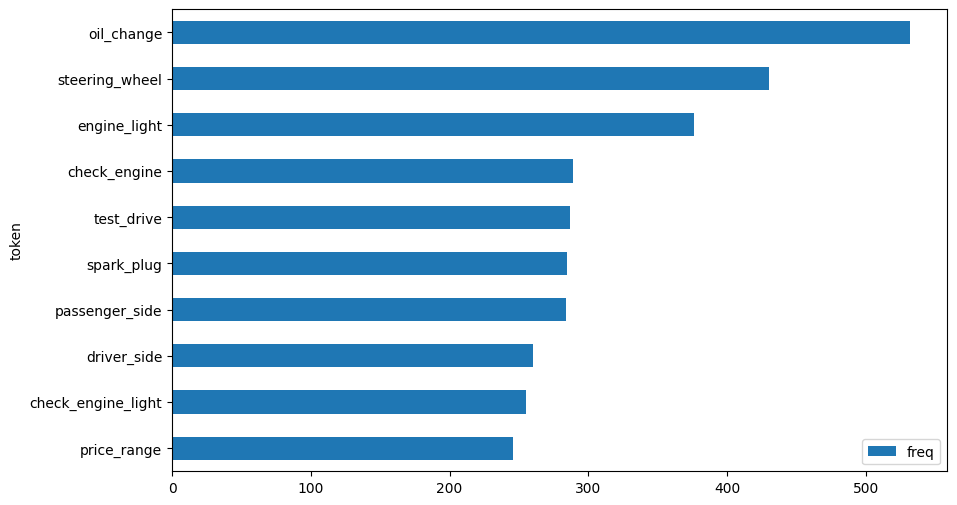

In [50]:
count_words(df['nouns_phrases']).head(10).plot(kind='barh', figsize=(10, 6)).invert_yaxis()

# Language Detection

## Language Detection with fastText

There are different trained models available on the fastText website. We will be using the smaller model lid.176.ftz which has a size of less than 1 MB and is almost as accurate as the large model with 126MB. See https://fasttext.cc/docs/en/language-identification.html for instructions.

In [51]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2023-12-26 16:59:22--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: 'lid.176.ftz'

lid.176.ftz         100%[===================>] 916.03K  --.-KB/s    in 0.05s   

2023-12-26 16:59:23 (18.4 MB/s) - 'lid.176.ftz' saved [938013/938013]



In [52]:
import fasttext


lang_model = fasttext.load_model("lid.176.ftz")

print(lang_model.predict('"Good morning" in German is "Guten Morgen"', 3))

(('__label__en', '__label__de', '__label__te'), array([0.97039694, 0.00256404, 0.00231963]))


In [53]:
lang_model.predict('"Good morning" in German is "Guten Morgen"', 3)

(('__label__en', '__label__de', '__label__te'),
 array([0.97039694, 0.00256404, 0.00231963]))

The predict function takes a Unicode string as its first argument. The second, optional parameter k specifies that we want the k language labels with the highest probabilities.

The model returns labels in the form `__label__<code>`, where code is the ISO 639 language code<footnote>See https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes for a complete list.</footnote> and probabilites for each label.

Let's wrap the language identification into a preprocessing function. The function returns the detected language only if the calculated probability is higher than the specified threshold, otherwise, it returns the default language. This is useful for corpora like the hacker news, which is basically an English corpus with some utterances from other languages.

In [54]:
def predict_language(text, threshold=0.8, default='en'):
    
    # skip language detection for very short texts
    if len(text) < 20:
        return default

    # fasttext requires single line input
    text = text.replace('\n', ' ')
    
    labels, probas = lang_model.predict(text)
    lang = labels[0].replace("__label__", "")
    proba = probas[0]
    
    if proba < threshold:
        return default
    else:
        return lang

In [55]:
data = ["I don't like version 2.0 of Chat4you 😡👎",   # English
        "Ich mag Version 2.0 von Chat4you nicht 😡👎", # German
        "Мне не нравится версия 2.0 Chat4you 😡👎",    # Russian
        "Não gosto da versão 2.0 do Chat4you 😡👎",    # Portugese
        "मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎"]   # Hindi
demo_df = pd.Series(data, name='text').to_frame()

demo_df['lang'] = demo_df['text'].apply(predict_language)
demo_df

,text,lang
0,I don't like version 2.0 of Chat4you 😡👎,en
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi


In order to get the real names for the language codes, we can provide a mapping dictionary.

In [56]:
url = 'https://raw.githubusercontent.com/haliaeetus/iso-639/master/data/iso_639-1.csv'
lang_df = pd.read_csv(url)
lang_df = lang_df[['name', '639-1', '639-2']].melt(id_vars=['name'], var_name='iso', value_name='code')

# create dictionary with entries {'code': 'name'}
iso639_languages = lang_df.set_index('code')['name'].to_dict()

In [57]:
demo_df['lang_name'] = demo_df['lang'].map(iso639_languages)
demo_df

,text,lang,lang_name
0,I don't like version 2.0 of Chat4you 😡👎,en,English
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de,German
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru,Russian
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt,Portuguese
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi,Hindi
